# Conditional Deep Convolutional GAN

There are two motivations for making use of the class label information in a GAN model.

    Improve the GAN.
    Targeted Image Generation.

Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality.

Class labels can also be used for the deliberate or targeted generation of images of a given type.

A limitation of a GAN model is that it may generate a random image from the domain. There is a relationship between points in the latent space to the generated images, but this relationship is complex and hard to map.




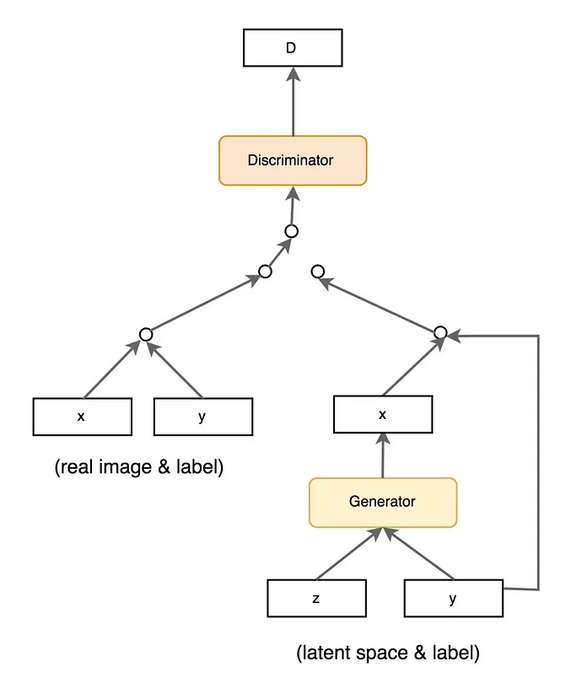

### Setting up GPU devices

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

import tensorflow as tf
print(tf.__version__)
if tf.test.gpu_device_name():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.13.0
Default GPU Device: /device:GPU:0


### Required Libraries

In [ ]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Activation, LeakyReLU, Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Embedding
import tensorflow_datasets as tfds


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

### Loading Data
- Normalization
- Reshaping

In [ ]:
# Get train and test sets
(X_train, y_train), (_, _) = mnist.load_data()

# Rescale between -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
y_train = np.expand_dims(y_train, axis=1)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
(buffer_size,img_rows, img_cols, channels) = X_train.shape
img_shape  = (img_rows, img_cols, channels)
z_dim      = 20     # dimensions of latent code
batch_size = 256
num_epochs = 100
each_save  = 5

path_results = '/content/'

#### Generating batches

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size).batch(batch_size)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

### Generator Architecture

In [ ]:
def build_generator(img_shape, z_dim, n_classes = 10, verbose=False):
    '''
    Generates a 28x28x1 image from a random vector of 100 inputs (latent space) conditioned by a label entry,
    which will indicate the number to be generated.
    '''

    z = Input(shape=(z_dim,))
    y = Input(shape=(1,))


    Y = Embedding(n_classes, 50)(y)
    Y = Dense(7 * 7, input_dim = 50)(Y)
    Y = Reshape((7, 7, 1))(Y)


    X = Dense(256 * 7 * 7, input_dim=z_dim) (z)
    X = Reshape((7, 7, 256))(X)
    X = Concatenate()([X, Y])

    X = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)

    X = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)

    output = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation ='tanh')(X)
    generator_model = Model(inputs = [z, y], outputs = [output], name ='generator')

    return generator_model

In [ ]:
generator = build_generator(img_shape, z_dim)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_2[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 12544)                263424    ['input_1[0][0]']             
                                                                                          

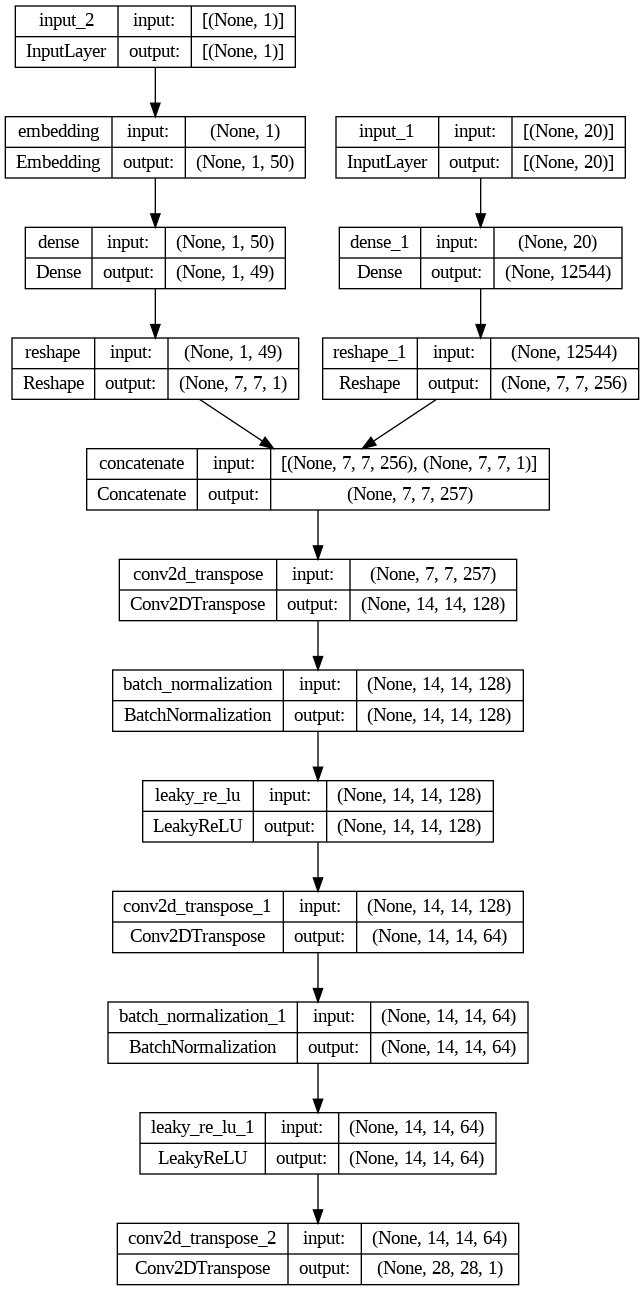

In [ ]:
plot_model(generator, show_shapes=True)

new width = (n-1) * stride - 2 * padding + kernel_size

### Discriminator Architecture

In [ ]:
def build_discriminator(img_shape, n_classes = 10, verbose=False):

    Xin = Input(shape=(img_shape[0],img_shape[1],img_shape[2],))
    Yin = Input(shape=(1,))

    Y   = Embedding(n_classes, 50)(Yin)

    Y   = Dense(img_shape[0] * img_shape[1] * img_shape[2], input_dim = 50)(Y)
    Y   = Reshape(img_shape)(Y)

    X   = Concatenate()([Xin, Y])

    X = Conv2D(filters=32, kernel_size = 3, strides= 2, input_shape = (img_shape[0],img_shape[1],img_shape[2] + 1), padding = 'same')(X)
    #X = BatchNormalization()(X)
    X = LeakyReLU(alpha = 0.01)(X)

    X = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha = 0.01)(X)

    X = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)

    X = Flatten()(X)
    Yout = Dense(1, activation='sigmoid')(X)

    discriminator_model = Model(inputs = [Xin, Yin], outputs = [Yout], name ='discriminator')

    return discriminator_model

In [ ]:
discriminator = build_discriminator(img_shape)
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 1, 784)               39984     ['embedding_1[0][0]']         
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                      

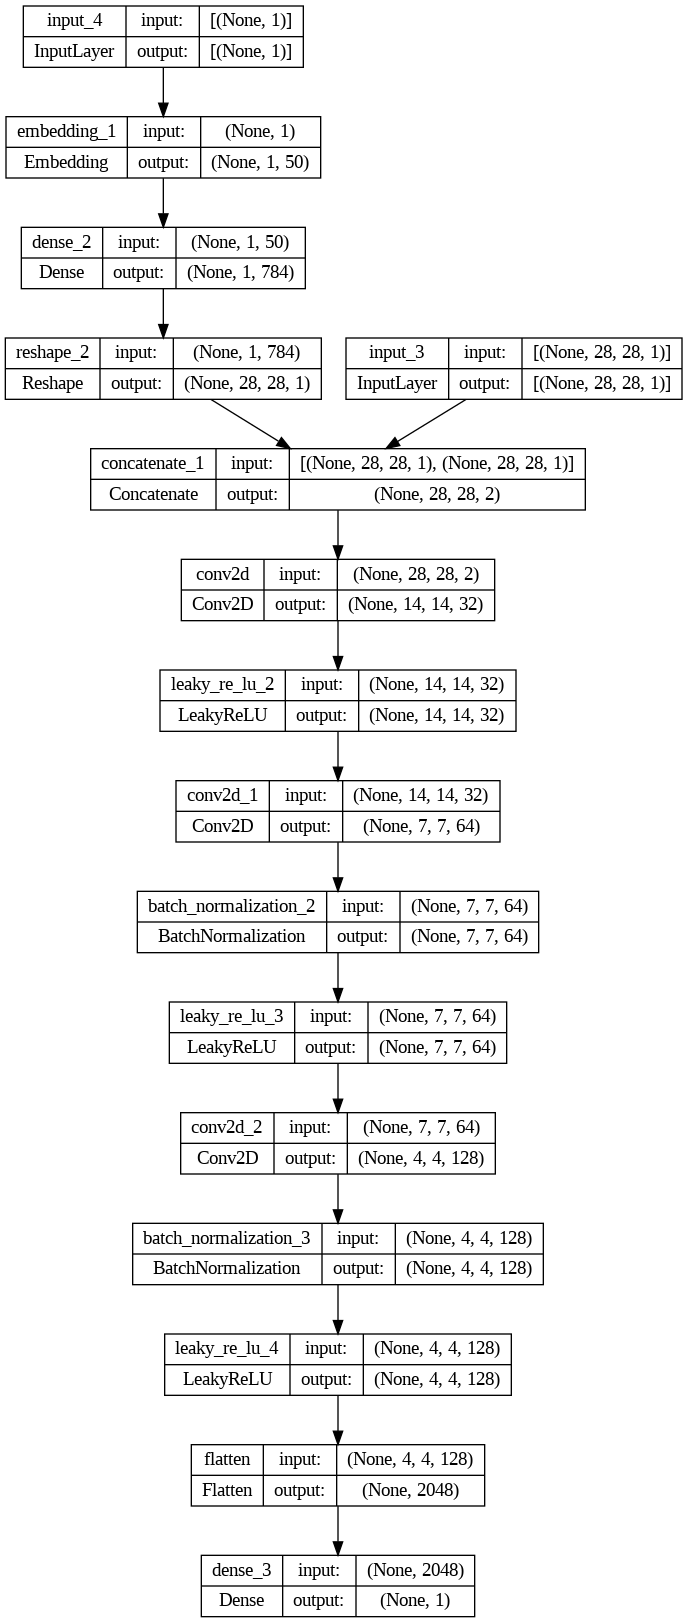

In [ ]:
plot_model(discriminator, show_shapes=True)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Loss for GAN

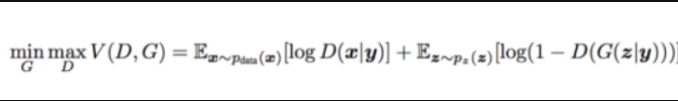

In [ ]:
# For Discriminator
def discriminator_loss_classic(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(tf.keras.backend.log(real_output) + tf.keras.backend.log(1.- fake_output))
    return total_loss

In [ ]:
# For Generator
def generator_loss_classic(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(real_output,fake_output):
    total_loss = -tf.reduce_mean(tf.keras.backend.log(fake_output))
    return total_loss

In [ ]:
generator_optimizer     = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [ ]:
@tf.function
def train_step(images, labels):
    # noise or latent code vector (same shape as image)
    z = tf.random.normal([images.shape[0], z_dim])

    # Generating fake label for this latent code
    y = tf.random.uniform(shape=[images.shape[0], ], minval=0, maxval=10, dtype=tf.int64)


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([z, y], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, y], training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss  = generator_loss(real_output, fake_output)


    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
from PIL import Image
import imageio
import glob
plt.rcParams['figure.dpi'] = 200

image_grid_rows = 10
image_grid_columns = 4

num_examples_to_generate = image_grid_rows * image_grid_columns
seed           = tf.random.normal([num_examples_to_generate, z_dim])
lst            = range(0,10)
lst            = list(itertools.chain.from_iterable(itertools.repeat(x, 4) for x in lst))
labels_seed    = tf.convert_to_tensor(lst)

def generate_and_save_images(model, epoch, test_input, pathdir=path_results):

    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 23), sharey=True, sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(predictions[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % lst[cnt])
            cnt += 1

    plt.savefig(pathdir+'image_epch_{:04d}.png'.format(epoch))
    plt.show()

def display_image(epoch_no, pathdir=path_results):
    return Image.open(pathdir+'image_epch_{:04d}.png'.format(epoch_no))

In [ ]:
from IPython import display
import time

def train(dataset, epochs):
  generator_losses=[]
  discriminator_losses=[]
  for epoch in range(epochs):
      start = time.time()

      for (image_batch, labels_batch) in dataset:
          gen_loss, disc_loss = train_step(image_batch, labels_batch)

      generator_losses.append(gen_loss)
      discriminator_losses.append(disc_loss)

      if (epoch+1)%each_save ==0:
          display.clear_output(wait=True)
          generate_and_save_images(generator,
                                    epoch + 1,
                                    [seed, labels_seed])

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                              epochs,
                              [seed, labels_seed])

  return np.array(generator_losses), np.array(discriminator_losses)

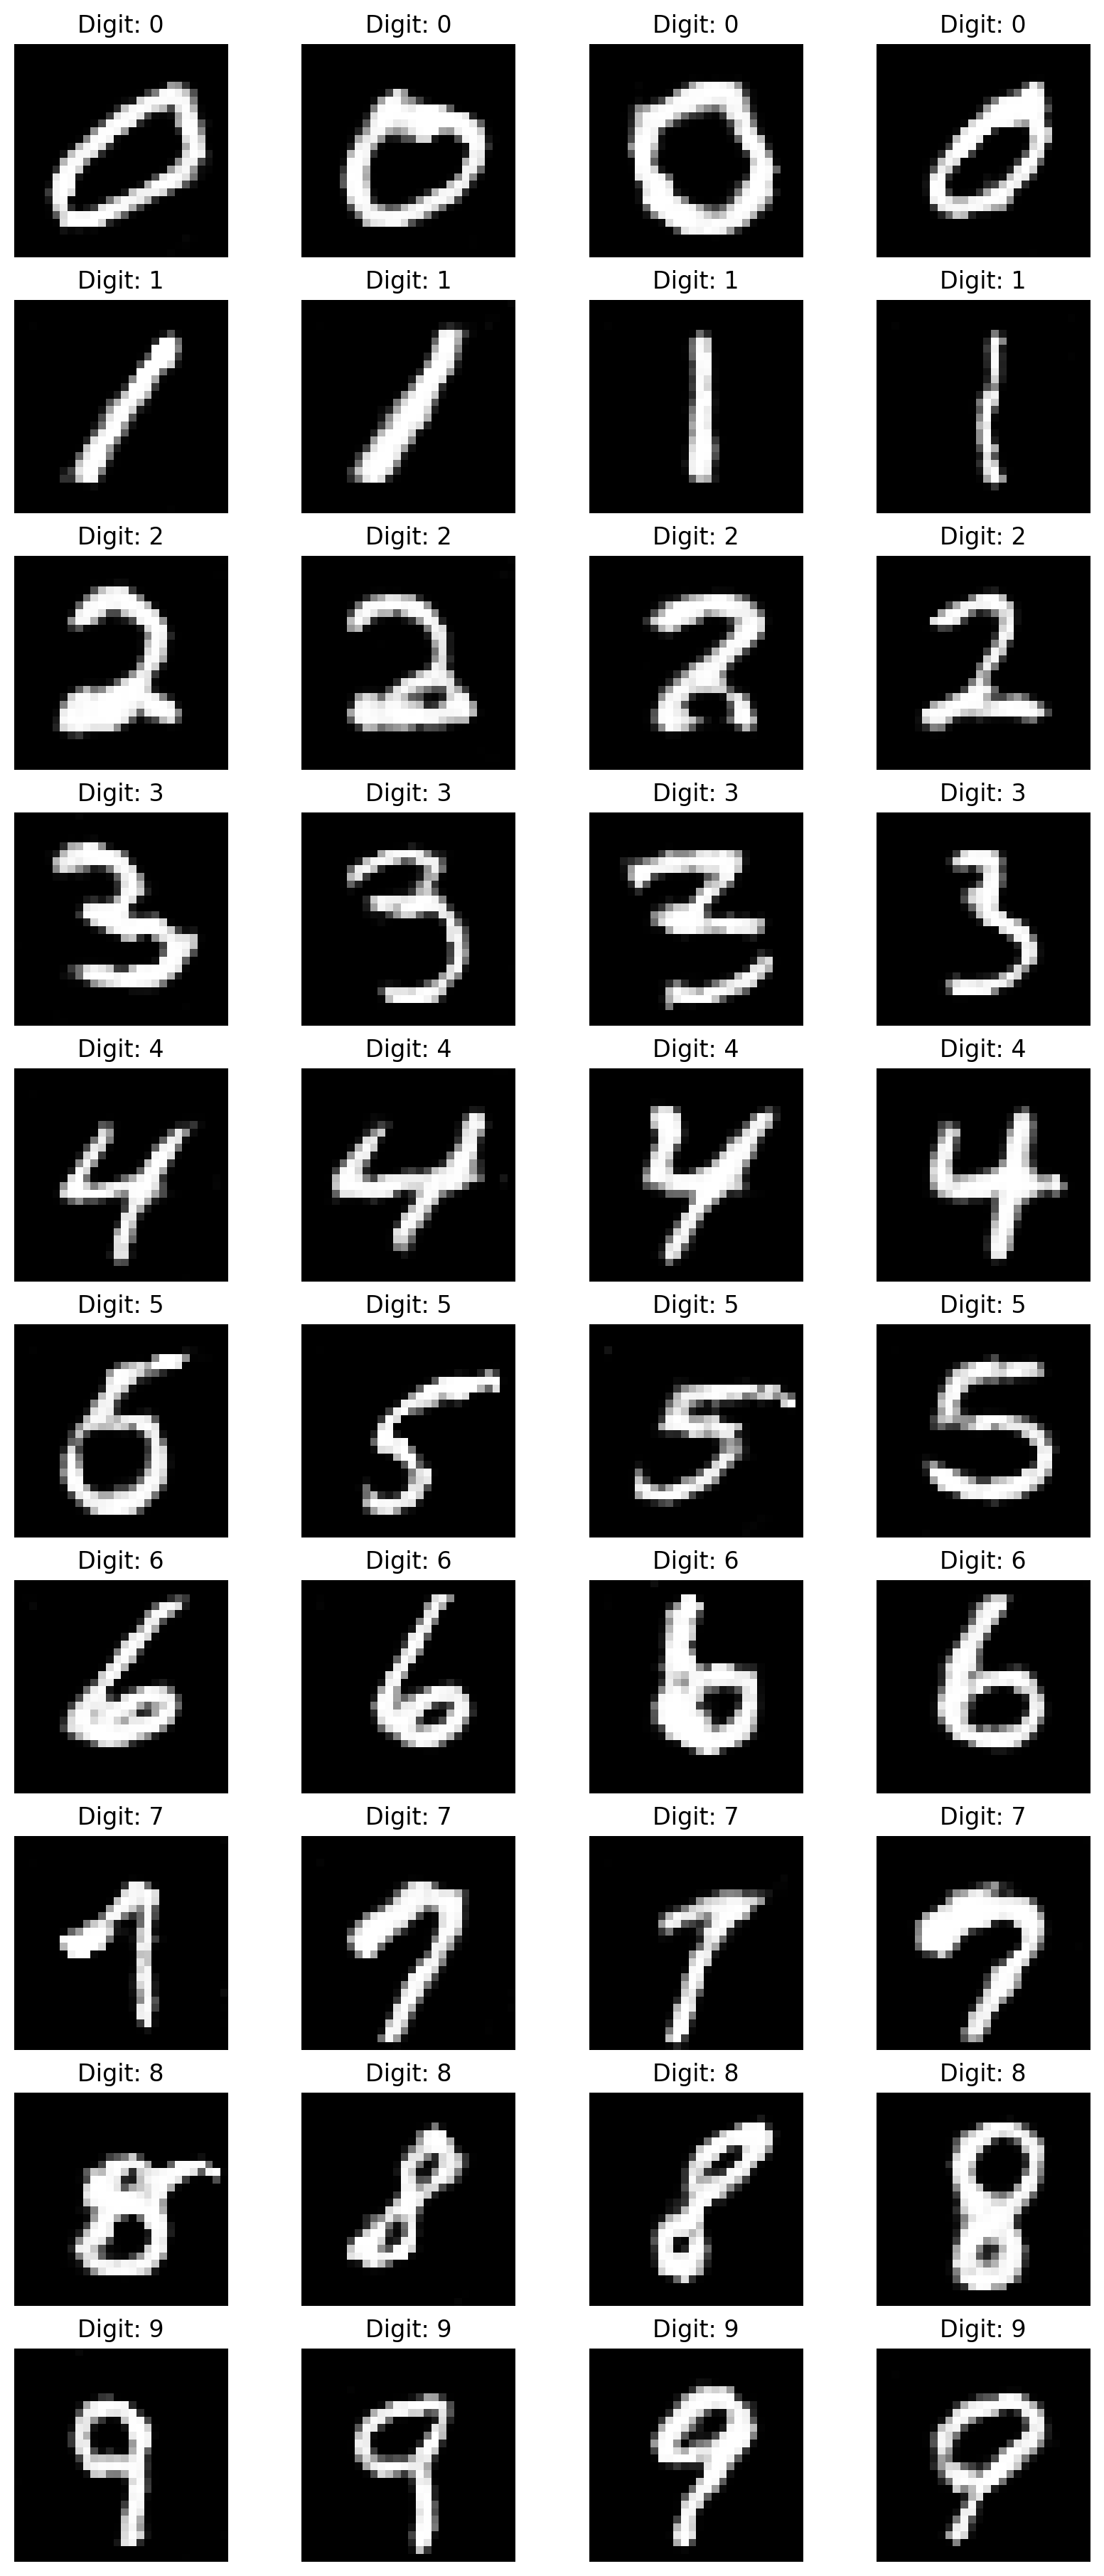

In [ ]:
generator_losses, discriminator_losses = train(train_dataset, num_epochs)

In [ ]:
# display_image(num_epochs)

### Saving the model

In [ ]:
generator.save_weights('/content/con_dcgan_generator_0_1.h5')
discriminator.save_weights('/content/con_dcgan_discriminator_0_1.h5')

In [ ]:
# generator.load_weights('con_dcgan_generator_0_1.h5')
# discriminator.load_weights('con_dcgan_discriminator_0_1.h5')

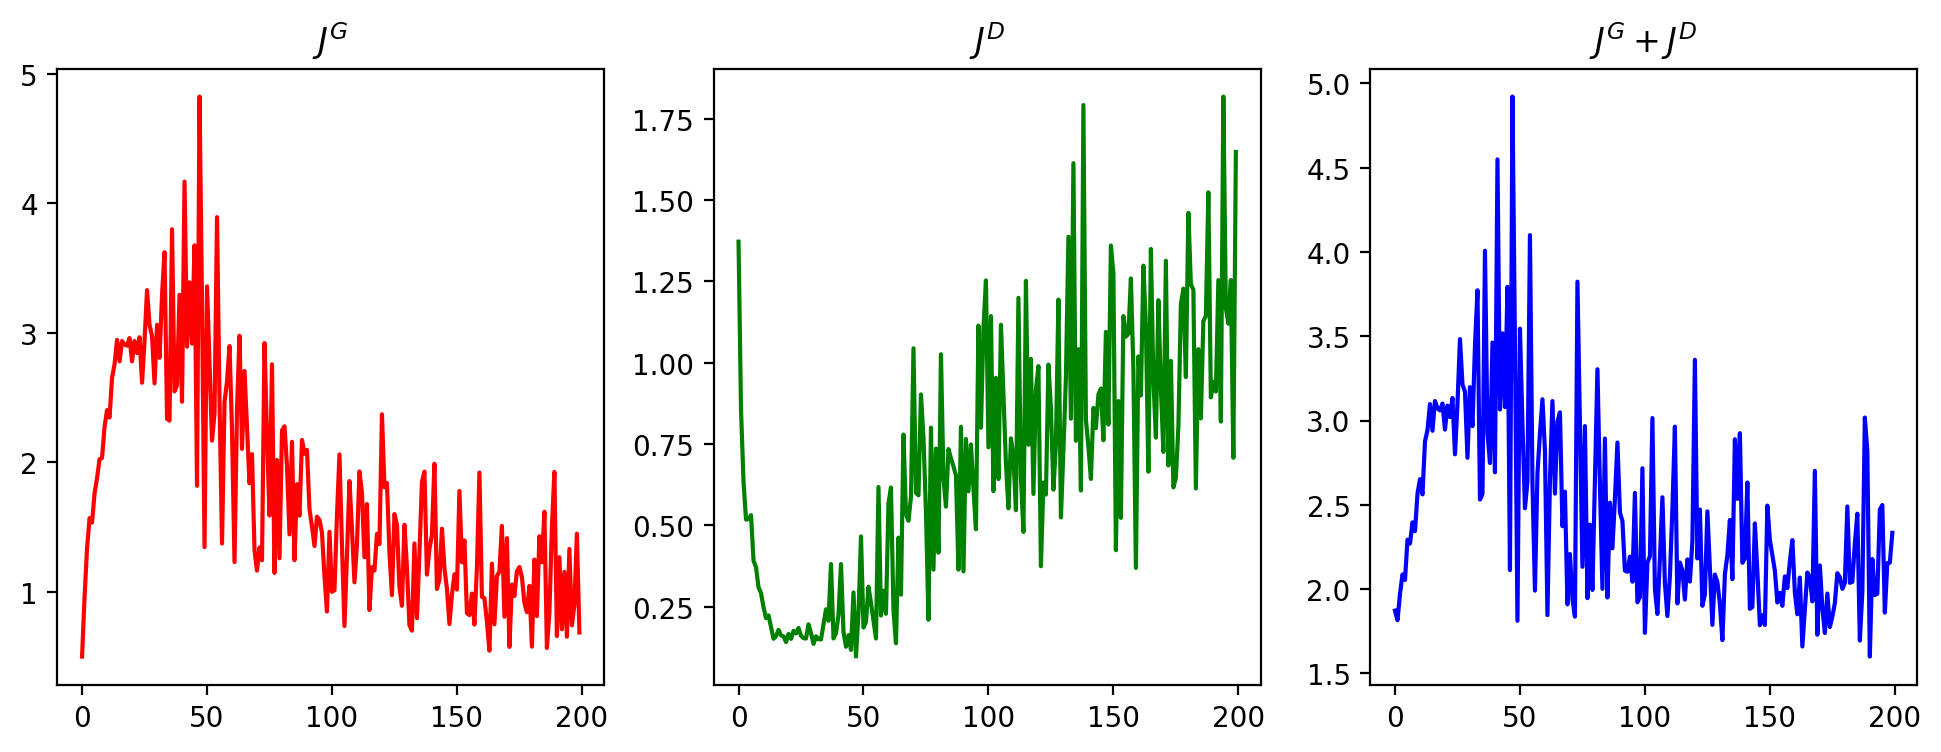

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(generator_losses, 'r')
plt.title('$J^G$')
plt.subplot(132)
plt.plot(discriminator_losses, 'g')
plt.title('$J^D$')
plt.subplot(133)
plt.plot(generator_losses+discriminator_losses, 'b')
plt.title('$J^G+J^D$')
plt.show()